The aim of this notebook is to use the Levenberg–Marquardt algorithm to fit a logistic function onto cumulative global COVID-19 recoveries.

Author: Aditya Ranjan

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [46]:
#Import essential libraries
import math
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [47]:
#Load data into a pandas data frame
#Source - https://www.google.com/search?q=john+hopkins+github
data = pd.read_csv("globalRecovered.csv")
data = data.drop(["Province/State", "Country/Region", "Lat", "Long"], axis = 1)
data.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,472,502,558,558,610,648,691,745,745,778,801,850,930,938,996,1040,1075,1097,1128,1138,1209,1259,1303,1328,1428,1450,1522,1585,1762,1830,1875,2171,2651,3013,3326,3928,4201,4725,5164,5508
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,620,627,650,654,682,688,694,705,714,715,727,742,758,771,777,783,789,795,803,812,823,851,857,872,877,891,898,898,910,925,938,945,960,980,1001,1034,1039,1044,1055,1064
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2467,2546,2678,2841,2998,3058,3158,3271,3409,3507,3625,3746,3968,4062,4256,4426,4784,4747,4918,5129,5277,5422,5549,5748,5894,6067,6218,6297,6453,6631,6717,6799,6951,7074,7255,7322,7420,7606,7735,7842
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,537,545,550,550,568,576,596,604,615,617,624,628,639,639,652,653,653,663,676,676,681,684,692,694,698,733,735,738,741,741,744,751,757,759,780,781,781,781,789,789
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,13,13,13,13,14,14,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,18,21,24,24,38,38,40,41,42,61,61,64,64


In [49]:
#Min-Max normalize data (prevents overflow errors and easier to work with in general)
x = np.array([i for i in range(len(y))])
x = (x - np.min(x)) / (np.max(x) - np.min(x))

y = np.sum(data, axis = 0)
y = (y - np.min(y)) / (np.max(y) - np.min(y))

In [50]:
#Important functions

#Logistic function
def model(p, x):
  return p[0] / (1 + (p[1] * (math.e ** (p[2] * x))))


#Returns residual: predicted - actual
def fun(p, x, y):
  return model(p, x) - y


#Returns the jacobian matrix: derivatives of residuals with respect to each parameter
def jac(p, x, y):
  J = np.empty((x.size, p.size))
  J[:, 0] = 1 / (1 + (p[1] * (math.e ** (p[2] * x))))
  J[:, 1] = (-p[0] * (math.e ** (p[2] * x))) / ((1 + ((math.e ** (p[2] * x)) * p[1])) ** 2)
  J[:, 2] = (-p[0] * p[1] * x * (math.e ** (p[2] * x))) / ((1 + ((math.e ** (p[2] * x)) * p[1])) ** 2)
  return J

In [51]:
#Scipy least squares method

#Initialize parameters
p0 = np.array([1, randint(100, 200), randint(-10, -5)])

#Use scipy least squares to minimize the cost
bestP = least_squares(fun, p0, jac = jac, args = (x, y), verbose = 1)

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 5.2791e+00, final cost 1.6112e-01, first-order optimality 5.22e-03.


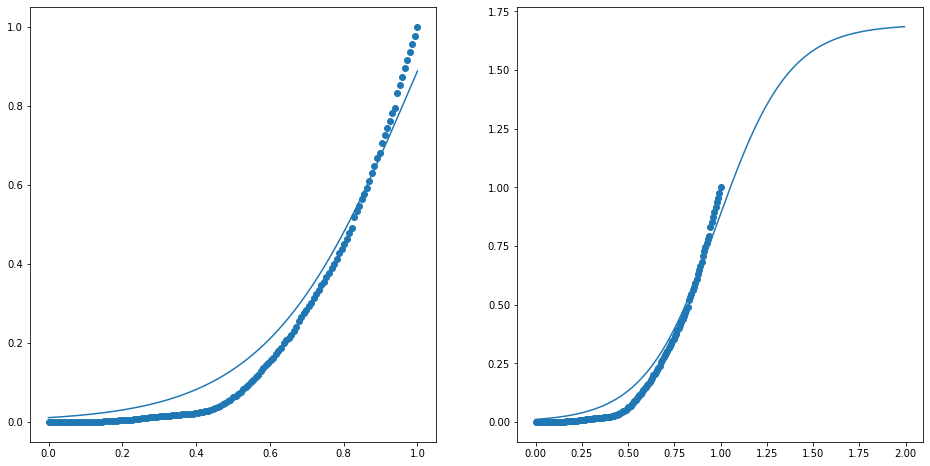

[  1.694461   151.96565986  -5.11935215]


In [52]:
#Plot the predicted values against the actual values
plt.rcParams["figure.figsize"] = (16, 8)

plt.subplot(121)
plt.scatter(x, y)
plt.plot(x, model(bestP.x, x))

plt.subplot(122)
tempX = np.arange(0, 2, x[1])
plt.scatter(x, y)
plt.plot(tempX, model(bestP.x, tempX))

plt.show()

#Parameter values after using scipy least squares
print(bestP.x)

In [80]:
#Using the Levenberg–Marquardt algorithm
#Source - https://mads.lanl.gov/presentations/Leif_LM_presentation_m.pdf

#Initialize parameters
p0 = np.array([1, randint(100, 200), randint(-10, -5)])
d, dUp, dDown = 1, 2, 2

temp = []

#Levenberg–Marquardt algorithm
for i in range(50):
  res, derivs = fun(p0, x, y), jac(p0, x, y)
  temp.append(np.sum(res))

  g = np.dot(derivs.T, derivs) + d
  costGrad = np.dot(derivs.T, res)
  cost = np.sum(0.5 * (res ** 2))

  pNew = p0 - np.dot(np.linalg.inv(g), costGrad)
  resNew = fun(pNew, x, y)
  costNew = np.sum(0.5 * (resNew ** 2))

  if costNew < cost:
    p0 = pNew
    d /= dDown
  else:
    d *= dUp

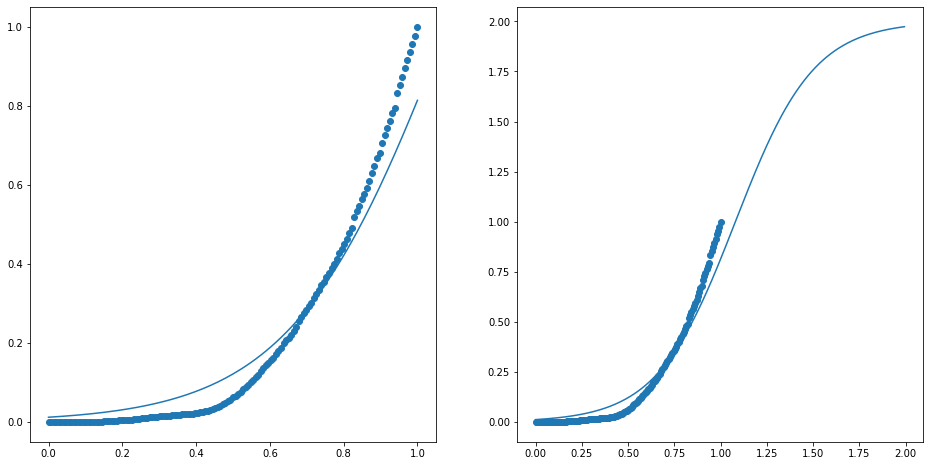

[  2.00019429 163.72075324  -4.72094753]


In [81]:
#Plot the predicted values against the actual values
plt.subplot(121)
plt.scatter(x, y)
plt.plot(x, model(p0, x))

plt.subplot(122)
plt.scatter(x, y)
plt.plot(tempX, model(p0, tempX))

plt.show()

#Parameter values after executing the Levenberg–Marquardt algorithm
print(p0)

While using scipy least squares consistently produced the same results each time I ran it, using the Levenberg–Marquardt algorithm seems to be highly inconsistent with the recoveries data and after running it several times, I had to change the initial damping parameter to 1 which decreases the step size. Only after doing this did I get reasonable results and even then, it's quite different from the results obtained by scipy least squares. This shows how sensitive the Levenberg–Marquardt algorithm is to damping parameters and initial guesses.